## Introduction

In this project, I will conduct a detailed statistical analysis of customer data from a telecommunications company to identify factors that influence customer retention and churn. I will use hypothesis tests to draw conclusions about customer characteristics and create simple predictive models, such as linear regression and logistic regression, to predict the probability of churn. Finally, I will prepare a detailed report with my findings and recommendations.



## Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
file_path = '/content/drive/My Drive/Data_Science/Telco_Customer_Churn.csv'
df = pd.read_csv(file_path)

## Data Cleaning and Preprocessing

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Binarizing the data
df[['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})

df['MultipleLines'] = df['MultipleLines'].replace({'Yes': 1, 'No': 0, 'No phone service': 0}); df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})
df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' ]] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace({'Yes': 1, 'No': 0, 'No internet service': 0})

df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))

In [7]:
# Handle missing/nan values
empty_values = df['TotalCharges'][df['TotalCharges'] == ' '].index.tolist()
df.loc[empty_values, 'TotalCharges'] = np.nan
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

## Exploratory Data Analysis (EDA)

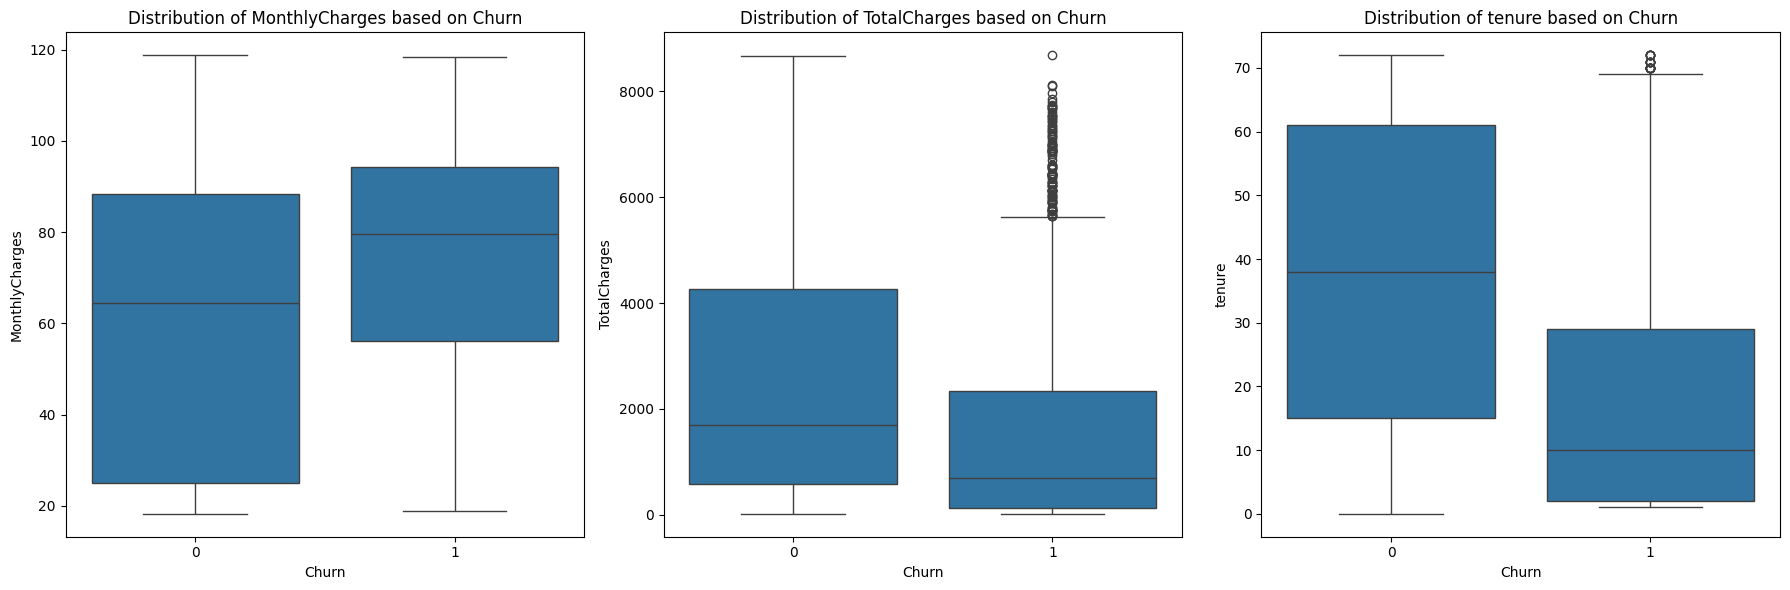

In [8]:
# Define the numeric features to plot
numeric_features = ['MonthlyCharges', 'TotalCharges', 'tenure']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each feature in a separate subplot
for i, column in enumerate(numeric_features):
    sns.boxplot(x='Churn', y=column, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} based on Churn')

plt.tight_layout()
plt.show()

> The boxplots show noticeable differences between customers who churn (1) and those who do not (0) in terms of monthly charges and total charges:
>
>* **Monthly Charges:** Customers who churn tend to have higher average monthly charges compared to those who stay.
* **Total Charges:** Customers who churn have lower total charges. This is because they often leave within the first few weeks, resulting in a shorter tenure.
* **Tenure:** The shorter tenure for customers who churn indicates that long-term customers are less likely to leave the service.



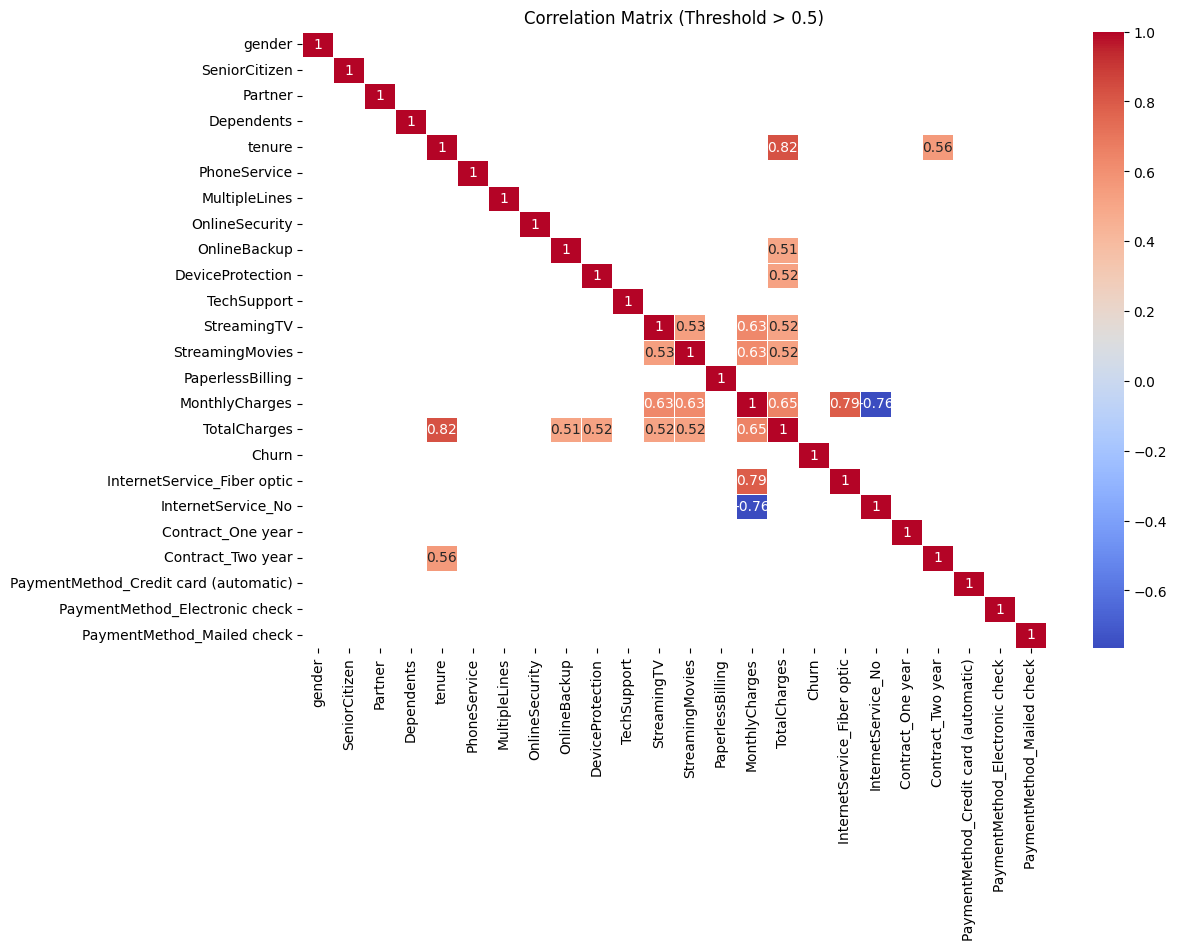

In [9]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Generate the correlation matrix
corr_matrix = numerical_df.corr()

# Filter the correlation matrix to show only correlations that exceed the threshold
threshold = 0.5
filtered_corr_matrix = corr_matrix[(corr_matrix >= threshold) | (corr_matrix <= -threshold)]

# Visualize the filtered correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=(filtered_corr_matrix==0))
plt.title('Correlation Matrix (Threshold > 0.5)')
plt.show()



> The correlation matrix shows the relationships between various numerical features. Notably, we observe high correlations between certain pairs of variables, indicating multicollinearity. For instance:
>
>* **Tenure and Total Charges:** There is a strong positive correlation between tenure and total charges. This is expected as longer tenure typically results in higher total charges.
>* **Total Charges and Services:** Variables such as fiber optic service and streaming TV are also highly correlated with total charges, as these services contribute significantly to the overall charges.
>
>These correlations suggest that these pairs of variables share significant information, and this should be considered during further analysis to avoid issues related to multicollinearity.



## Statistical Analysis

In [10]:
features = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges','InternetService_Fiber optic', 'InternetService_No','Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

# Filter Data to Identify Abandonment
churned = df[df['Churn'] == 1]; not_churned = df[df['Churn'] == 0]

# t test
for feature in features:
    t_stat, p_val = ttest_ind(churned[feature], not_churned[feature])
    print(f'Test t para {feature}:')
    print(f'Estadístico t: {t_stat}, Valor p: {p_val}\n')


Test t para SeniorCitizen:
Estadístico t: 12.80786572603475, Valor p: 3.8398600557847846e-37

Test t para Partner:
Estadístico t: -12.769496308938553, Valor p: 6.2207311296211236e-37

Test t para Dependents:
Estadístico t: -13.96958531142715, Valor p: 9.14043298908859e-44

Test t para tenure:
Estadístico t: -31.57955051135377, Valor p: 7.99905796059022e-205

Test t para MultipleLines:
Estadístico t: 3.3677053035527216, Valor p: 0.0007620291315109993

Test t para OnlineSecurity:
Estadístico t: -14.58307921541945, Valor p: 1.763258816853781e-47

Test t para OnlineBackup:
Estadístico t: -6.925529254735977, Valor p: 4.7272917320565105e-12

Test t para DeviceProtection:
Estadístico t: -5.5637020444241765, Valor p: 2.7381602498197644e-08

Test t para TechSupport:
Estadístico t: -14.009118640103008, Valor p: 5.322253267505446e-44

Test t para StreamingTV:
Estadístico t: 5.316119229762752, Valor p: 1.0926020701630738e-07

Test t para StreamingMovies:
Estadístico t: 5.160297007230678, Valor p: 



> For the next steps, I will select only some relevant variables with a p-value less than 0.05. This approach helps to avoid **overfitting** and **multicollinearity**. Overfitting happens when a model is too complex and captures noise in the data, while multicollinearity occurs when variables are highly correlated with each other, making it hard to determine their individual effects.



In [11]:
# frequent values
average_customer = df.mode().iloc[0]
print("Average Customer Profile:")
print(average_customer)


Average Customer Profile:
customerID                               0002-ORFBO
gender                                          1.0
SeniorCitizen                                   0.0
Partner                                         0.0
Dependents                                      0.0
tenure                                          1.0
PhoneService                                    1.0
MultipleLines                                   0.0
OnlineSecurity                                  0.0
OnlineBackup                                    0.0
DeviceProtection                                0.0
TechSupport                                     0.0
StreamingTV                                     0.0
StreamingMovies                                 0.0
PaperlessBilling                                1.0
MonthlyCharges                                20.05
TotalCharges                                   20.2
Churn                                           0.0
InternetService_Fiber optic           

## Predictive Modeling

    Logistic Regression | Objective: Predict the probability of customers leaving the company (churn).

In [12]:
# Define the features and target
features = ['tenure', 'MonthlyCharges', 'Contract_Two year', 'TechSupport' ]
X = df[features]
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1414  125]
 [ 300  274]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.69      0.48      0.56       574

    accuracy                           0.80      2113
   macro avg       0.76      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113





> The model is better at predicting customers who do not churn (Class 0) compared to those who do churn (Class 1). The macro average F1-score is 0.72, indicating a balanced performance across both classes.



## Evaluation and Validation

In [13]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')
print(f'Standard Deviation of Cross-Validation Accuracy: {cv_scores.std()}')

Cross-Validation Accuracy Scores: [0.79701916 0.79276082 0.77856636 0.7890625  0.79048295]
Mean Cross-Validation Accuracy: 0.7895783598941868
Standard Deviation of Cross-Validation Accuracy: 0.006129309601829463




> The results of the cross-validation indicate that the model performs consistently well across different subsets of the data.



In [14]:
# Set random seed for reproducibility
np.random.seed(35)

# Generate random data for 5 new people
new_data_random = {
    'tenure': np.random.randint(1, 60, size=5),
    'MonthlyCharges': np.random.uniform(20, 100, size=5),
    'Contract_Two year': np.random.randint(0, 2, size=5),
    'TechSupport': np.random.randint(0, 2, size=5)
}

# Manually create a single new data point
new_data_manual = {
    'tenure': [2],
    'MonthlyCharges': [59],
    'Contract_Two year': [0],
    'TechSupport': [0]
}

# Convert the dictionaries into DataFrames
df_random = pd.DataFrame(new_data_random)
df_manual = pd.DataFrame(new_data_manual)

# Make predictions using the trained model
predictions_random = model.predict(df_random)
predictions_manual = model.predict(df_manual)

# Print the DataFrames and the predictions
print("Random Data Predictions:")
print(df_random)
print("Predictions:", predictions_random)

print("\nManual Data Prediction:")
print(df_manual)
print("Predictions:", predictions_manual)

Random Data Predictions:
   tenure  MonthlyCharges  Contract_Two year  TechSupport
0      10       39.688549                  1            1
1      16       22.250051                  0            0
2      45       75.686697                  0            0
3      56       61.342233                  0            1
4      34       68.388447                  1            0
Predictions: [0 0 0 0 0]

Manual Data Prediction:
   tenure  MonthlyCharges  Contract_Two year  TechSupport
0       2              59                  0            0
Predictions: [1]


    Linear Regression | Objective: Predict future customer monthly charges (income).

Mean Squared Error: 98.33224262506738
R^2 Score: 0.8905240464918451


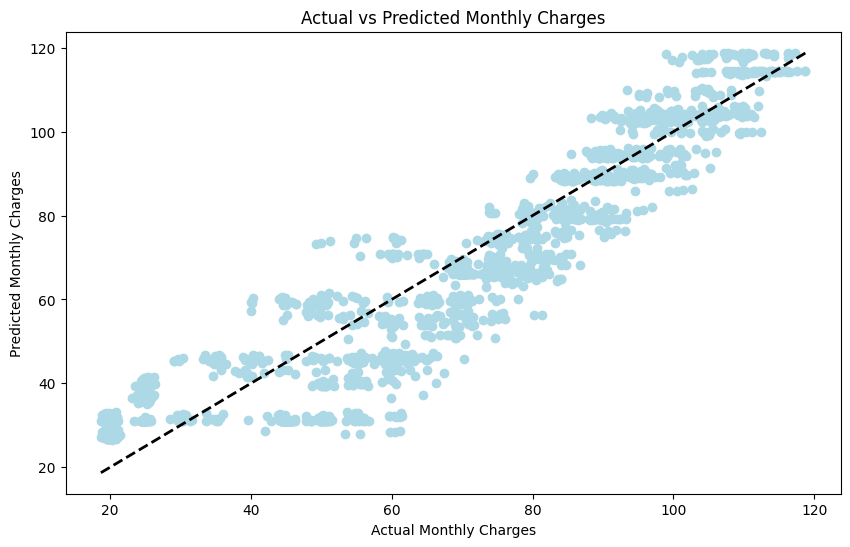

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features (independent variables) and target (dependent variable)
features = ['tenure', 'Contract_Two year', 'TechSupport', 'InternetService_Fiber optic', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
X = df[features]
y = df['MonthlyCharges']

# Split the data (training and testing sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error and R^2 Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='lightblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Monthly Charges')
plt.ylabel('Predicted Monthly Charges')
plt.title('Actual vs Predicted Monthly Charges')
plt.show()



> * MSE: The model has an average squared prediction error of 98.33.
* R^2 Score: The model explains 89% of the variance in the monthly charges, indicating a strong predictive power.
>
>These results suggest that the model is performing well in predicting the monthly charges of customers.



## Communication of Results

1. The **average customer** in the dataset is a male who is not a senior citizen and does not have a partner or dependents. This customer has been with the company for 1 month, has phone service but does not use multiple lines, online security, online backup, device protection, tech support, streaming TV, or streaming movies. The customer prefers paperless billing, has a low monthly charge of 20.05, and has accrued total charges of 20.2. This customer has not churned and uses DSL internet service, opting for a month-to-month contract rather than a one-year or two-year contract. The preferred payment method is bank transfer (automatic), as they do not use a credit card, electronic check, or mailed check.

2. Logistic Regression Results:

 * **Model Accuracy:** The logistic regression model predicts customer churn with an accuracy of 80%.
 * **Key Variables:** The most influential variables for predicting churn are tenure, monthly charges, contract type, and tech support.
 * **Practical Implications:** Customers with shorter tenures and higher monthly charges are more likely to churn. Long-term contracts and tech support services reduce churn probability.

3. Linear Regression Results:

 * **Key Variables:** The variables that best predict monthly charges are tenure, contract type, extra services, multiple lines and tech support.
 * **Model Performance:** The linear regression model has an R^2 score of 0.89, indicating that 89% of the variance in monthly charges is explained by the model. The mean squared error is 98.33.
 * **Future Income Prediction:** This model helps forecast future revenues by predicting monthly charges based on customer characteristics.

Based on these results, I recommend implementing loyalty programs to retain customers for longer periods, as they are less likely to leave over time. Additionally, it is important to ensure that new customers do not face high charges in their initial months to prevent early churn.